In [1]:
%matplotlib inline

from IPython import display
import io
import time

import logging

import matplotlib.pyplot as plt
import cv2
import boto3
from botocore.exceptions import ClientError
from sagemaker.predictor import Predictor
import sagemaker, json
from sagemaker import get_execution_role

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

import octank_utility as utility

logger = logging.getLogger(__name__)

### Initialize general parameters

In [2]:
role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()

bucket = sess.default_bucket()
account = sess.account_id()


prefix = 'octank_videos'

test_image = 'synthetic_data_106.jpg'

video_path = 'videos/movie-9053391.mp4'

s3 = boto3.client('s3')
object_name = f"{prefix}/{video_path.split('/')[-1]}"

response = s3.upload_file(video_path, bucket, object_name)

s3_path = f"s3://{bucket}/{object_name}"
print(s3_path)

s3://sagemaker-us-east-1-913089978341/octank_videos/movie-9053391.mp4


### Initialize parameters for Rekognition Object detection

In [3]:
project_arn='arn:aws:rekognition:us-east-1:913089978341:project/retail-test-2/1648085376750'
model_arn='arn:aws:rekognition:us-east-1:913089978341:project/retail-test-2/'+\
            'version/retail-test-2.2022-03-23T20.40.12/1648086013117'

version_name='retail-test-2.2022-03-23T20.40.12'

rekognition = boto3.client('rekognition')

### Initialize parameters for embedding search

In [4]:
# SageMaker endpoint
embedding_endpoint = 'jumpstart-example-infer-tensorflow-icem-2022-04-14-15-14-03-830'

# embedding model predictor
model_predictor = Predictor(endpoint_name = embedding_endpoint,
                           sagemaker_session = sess)


# Opensearch
opensearch_domain_endpoint = 'search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com'

index_name = 'image_embedding'

credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region)

opensearch_host = {
    'host' : opensearch_domain_endpoint,
    'port' : 443,
    'scheme' : 'https',
}

opensearch = OpenSearch(hosts = [opensearch_host],
               http_auth = auth,
                use_ssl = True,
                verify_certs = True,
                connection_class = RequestsHttpConnection)

### Initialize for DynamoDB

In [5]:
table_name = 'octank_movie'

dynamodb = boto3.resource('dynamodb')

## Becareful.  ONLY RUN THIS IF YOU ARE DONE

In [ ]:
def stop_rekognition_model(client, model_arn):

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')

# stop_rekognition_model(rekognition, model_arn)

In [ ]:
def start_rekognition_model(client, model_arn, project_arn, version_name, min_inference_units=1):   
    try:
        # Start the model
        logger.info('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            logger.info("Status: " + model['Status'])
            logger.info("Message: " + model['StatusMessage'])
    
    except Exception as e:
        logger.error(e)

    return model['Status']

In [ ]:
try:
    describe_response = rekognition.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])

    if len(describe_response['ProjectVersionDescriptions'])<1:
        logger.error('No model found..................')
        raise

    model = describe_response['ProjectVersionDescriptions'][0]

    status = model['Status']

    if status != "RUNNING":
        status = start_rekognition_model(rekognition, 
                                         model_arn, 
                                         project_arn, 
                                         version_name,
                                         1)
    
except ClientError as client_err:
    logger.error(format(client_err))
    raise
    
print(status)

In [6]:
from ipywidgets import widgets, HBox, VBox

def display_results(results):
    Vbox_list = []
    for distance, product_id in results:
        Vbox_list.append(VBox([widgets.Label(f"Score: {distance:.2f}"),
                               widgets.Label(f"Product ID: {product_id}"),
                               widgets.Image(value=open(f"../opensearch/images/{product_id}.jpg", 'rb').read())]))
    hbox = HBox(Vbox_list)
    display.display(hbox)

frame1 = cv2.imread(test_image)

height = frame1.shape[0]
width = frame1.shape[1]

image_bytes = cv2.imencode('.jpg', frame1)[1].tobytes()

results = utility.analyze_video_frame(rekognition, 
                             model_arn, 
                            image_bytes,
                            80)

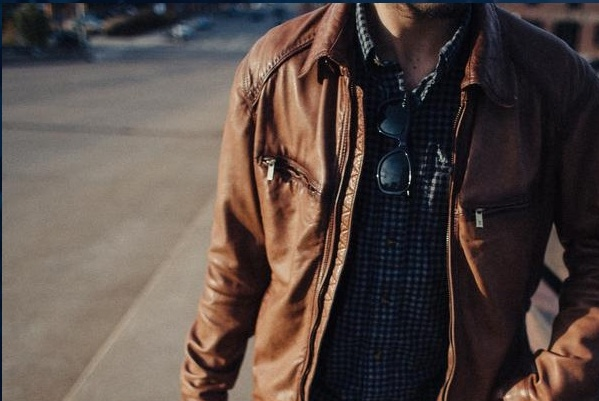

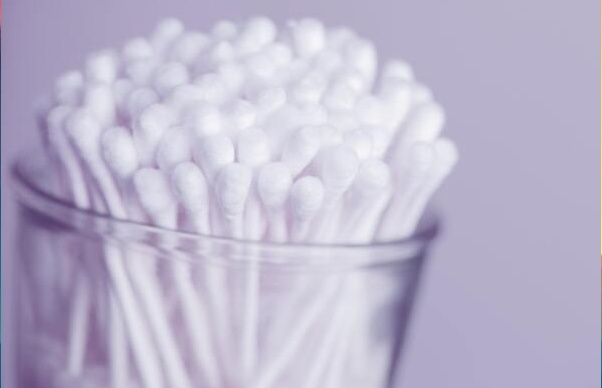

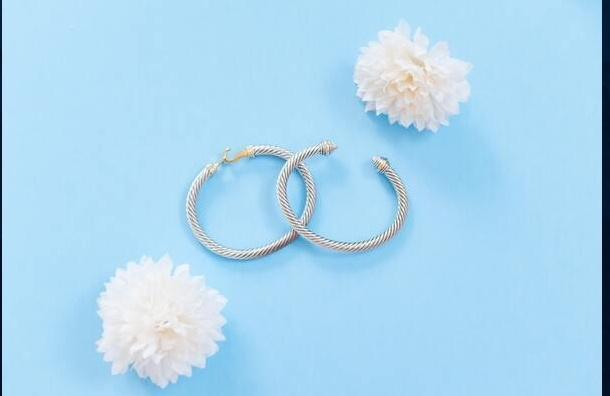

In [7]:
for product in results:
    cropped, bbox = utility.crop_images(frame1, product['Geometry']['BoundingBox'])
    
    cropped_bytes = cv2.imencode('.jpeg', cropped)[1].tobytes()
#     display.display(display.Image(data=cropped_bytes))
    
    embedding_vector = utility.generate_embedding(cropped_bytes, model_predictor)
    
    results = utility.knn_search(opensearch, index_name, 1, embedding_vector)
    
    
    display.display(display.Image(data=cropped_bytes))

    display_results(results)

In [7]:
def process_frames(frame):
    
    # get width and height info for each frame
    height = frame.shape[0]
    width = frame.shape[1]
    
    # send frame to Rekognition for inference

    image_bytes = cv2.imencode('.jpg', frame)[1].tobytes()
    results = utility.analyze_video_frame(rekognition, 
                                 model_arn, 
                                image_bytes,
                                80)
    
    detections = []
    for product in results:
        
        detect =dict()

        # crop images
        cropped, bbox = utility.crop_images(frame1, product['Geometry']['BoundingBox'])
    
        detect['bbox']=bbox

        cropped_bytes = cv2.imencode('.jpeg', cropped)[1].tobytes()

        # generate embedding
        embedding_vector = utility.generate_embedding(cropped_bytes, model_predictor)
        
        # search product info from OpenSearch
        results = utility.knn_search(opensearch, index_name, 1, embedding_vector)
        
        print(results)
        detect['product_id'] = results[0][1]
        detect['product_category'] = results[0][2]
        
        detections.append(detect)
    
    
    return detections
    
process_frames(frame1)

[[146.724, '134b991a-f336-4b73-ae44-247317af0130', 'apparel']]
[[222.50282, '59b0aeff-c1cc-4d7c-b928-dec5457942e0', 'beauty']]
[[160.23715, '8d4ea20c-19e5-4bc8-bdb3-7168e89bb176', 'jewelry']]


[{'bbox': {'top': 1226, 'bottom': 1627, 'left': 582, 'right': 1181},
  'product_id': '134b991a-f336-4b73-ae44-247317af0130',
  'product_category': 'apparel'},
 {'bbox': {'top': 1221, 'bottom': 1609, 'left': 1471, 'right': 2073},
  'product_id': '59b0aeff-c1cc-4d7c-b928-dec5457942e0',
  'product_category': 'beauty'},
 {'bbox': {'top': 1557, 'bottom': 1953, 'left': 3205, 'right': 3815},
  'product_id': '8d4ea20c-19e5-4bc8-bdb3-7168e89bb176',
  'product_category': 'jewelry'}]

In [23]:
from IPython.display import HTML
from base64 import b64encode
import cv2
import time

table = dynamodb.Table(table_name)
# check if Rekognition model is running, if not start...

# download image from s3
ready = utility.check_rekognition_model_status(rekognition,
                                       project_arn,
                                       version_name)

if ready:
    output = dict()
    
    #download file frame s3
    s3.download_file(bucket, object_name, video_path)

    
    output['video_id'] = video_path.split('/')[-1]
    output['detections'] = dict()
    # load the movie video
    cap = cv2.VideoCapture(video_path)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print('Frame count:', frame_count)
    frame_id = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
#     # print('Position:', cap.get(cv2.CAP_PROP_POS_FRAMES))

    display_handle=display.display(None, display_id=True)

    try:
        while True:
            _, frame = cap.read()
            
            detections = process_frames(frame)
            
            for d in detections:
                frame = utility.draw_bbox(cv2, frame, d['bbox'])
            
#             _, frame = cv2.imencode('.jpeg', frame)
#             display_handle.update(display.Image(data=frame.tobytes()))
#             time.sleep(2)

            output['detections'][str(frame_id)] = detections
            frame_id += 1
            if frame_id >= frame_count:
                break
        table.put_item(
            Item=output
        )
    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        display_handle.update(None)

None

In [ ]:
import pprint as pp

pp.pprint(output)

In [12]:
table.put_item(
    Item=output
)

{'ResponseMetadata': {'RequestId': 'LHCB19UB89O3KL9VPICM15CGQ3VV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Fri, 15 Apr 2022 21:32:27 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'LHCB19UB89O3KL9VPICM15CGQ3VV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '2745614147'},
  'RetryAttempts': 0}}

In [45]:
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

#Initialize the TensorFlowProcessor
tp = TensorFlowProcessor(
    framework_version='2.3',
    role=get_execution_role(),
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='octank-test',
    py_version='py37'
)

In [46]:
#Run the processing job
tp.run(
    code='video_processing.py',
    arguments=["--filename", s3_path.split('/')[-1]],
    source_dir='src',
    inputs=[
        ProcessingInput(
            source=s3_path,
            destination='/opt/ml/processing/input'
        )
    ]
)


Job Name:  octank-test-2022-04-16-00-39-28-047
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-913089978341/octank_videos/movie-9053391.mp4', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-913089978341/octank-test-2022-04-16-00-39-28-047/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-913089978341/octank-test-2022-04-16-00-39-28-047/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyR

POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.019s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.043s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.039s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.034s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.019s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.021s]
Finished running processing job



In [47]:
!mkdir docker

In [13]:
%%writefile docker/requirements.txt
opensearch-py
opencv-python
boto3
sagemaker
requests

Overwriting docker/requirements.txt


In [14]:
%%writefile docker/Dockerfile

FROM public.ecr.aws/docker/library/python:3.7
    
ADD requirements.txt /
ADD video_processing.py /
ADD octank_utility.py /

RUN apt-get update
RUN apt-get install ffmpeg libsm6 libxext6  -y
RUN pip3 install -r requirements.txt

ENV PYTHONUNBUFFERED=TRUE 
ENV TF_CPP_MIN_LOG_LEVEL="2"

ENTRYPOINT ["python3", "/video_processing.py"]

Overwriting docker/Dockerfile


In [9]:
container_name = "sagemaker-tf-container"
!cd docker && sm-docker build . --file Dockerfile --repository $container_name:2.0
    
ecr_image = "{}.dkr.ecr.{}.amazonaws.com/{}:2.0".format(account, region, container_name)

..[Container] 2022/04/17 20:33:13 Waiting for agent ping

[Container] 2022/04/17 20:33:14 Waiting for DOWNLOAD_SOURCE
[Container] 2022/04/17 20:33:16 Phase is DOWNLOAD_SOURCE
[Container] 2022/04/17 20:33:16 CODEBUILD_SRC_DIR=/codebuild/output/src127888946/src
[Container] 2022/04/17 20:33:16 YAML location is /codebuild/output/src127888946/src/buildspec.yml
[Container] 2022/04/17 20:33:16 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2022/04/17 20:33:16 Processing environment variables
[Container] 2022/04/17 20:33:16 No runtime version selected in buildspec.
[Container] 2022/04/17 20:33:16 Moving to directory /codebuild/output/src127888946/src
[Container] 2022/04/17 20:33:16 Configuring ssm agent with target id: codebuild:a8d83d26-0ea3-4668-a82c-70009ae96ae5
[Container] 2022/04/17 20:33:16 Successfully updated ssm agent configuration
[Container] 2022/04/17 20:33:16 Registering with agent
[Container] 2022/04/17 20:33:16 Phases found in YAML: 3
[Container] 2022/04

Selecting previously unselected package libvidstab1.1:amd64.
Preparing to unpack .../077-libvidstab1.1_1.1.0-2+b1_amd64.deb ...
Unpacking libvidstab1.1:amd64 (1.1.0-2+b1) ...
Selecting previously unselected package libavfilter7:amd64.
Preparing to unpack .../078-libavfilter7_7%3a4.3.3-0+deb11u1_amd64.deb ...
Unpacking libavfilter7:amd64 (7:4.3.3-0+deb11u1) ...
Selecting previously unselected package libslang2:amd64.
Preparing to unpack .../079-libslang2_2.3.2-5_amd64.deb ...
Unpacking libslang2:amd64 (2.3.2-5) ...
Selecting previously unselected package libcaca0:amd64.
Preparing to unpack .../080-libcaca0_0.99.beta19-2.2_amd64.deb ...
Unpacking libcaca0:amd64 (0.99.beta19-2.2) ...
Selecting previously unselected package libcdio19:amd64.
Preparing to unpack .../081-libcdio19_2.1.0-2_amd64.deb ...
Unpacking libcdio19:amd64 (2.1.0-2) ...
Selecting previously unselected package libcdio-cdda2:amd64.
Preparing to unpack .../082-libcdio-cdda2_10.2+2.0.0-1+b2_amd64.deb ...
Unpacking libcdio-cd

Selecting previously unselected package mesa-vulkan-drivers:amd64.
Preparing to unpack .../143-mesa-vulkan-drivers_20.3.5-1_amd64.deb ...
Unpacking mesa-vulkan-drivers:amd64 (20.3.5-1) ...
Selecting previously unselected package pocketsphinx-en-us.
Preparing to unpack .../144-pocketsphinx-en-us_0.8+5prealpha+1-13_all.deb ...
Unpacking pocketsphinx-en-us (0.8+5prealpha+1-13) ...
Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../145-va-driver-all_2.10.0-1_amd64.deb ...
Unpacking va-driver-all:amd64 (2.10.0-1) ...
Selecting previously unselected package vdpau-driver-all:amd64.
Preparing to unpack .../146-vdpau-driver-all_1.4-3_amd64.deb ...
Unpacking vdpau-driver-all:amd64 (1.4-3) ...
Setting up libgme0:amd64 (0.6.3-2) ...
Setting up libssh-gcrypt-4:amd64 (0.9.5-1+deb11u1) ...
Setting up libsrt1.4-gnutls:amd64 (1.4.2-1.3) ...
Setting up libxcb-dri3-0:amd64 (1.14-3) ...
Setting up libudfread0:amd64 (1.1.1-1) ...
Setting up libwayland-server0:amd64 (1.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 KB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 KB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.7/521.7 KB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 KB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━

2df4ed051e25: Pushed
bc0c9d226300: Pushed
2.0: digest: sha256:841928912297bae0225d8862b8a8db396a78e4287bf64fe6e78ee8059ae226da size: 3480

[Container] 2022/04/17 20:35:13 Phase complete: POST_BUILD State: SUCCEEDED
[Container] 2022/04/17 20:35:13 Phase context status code:  Message:

Image URI: 913089978341.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tf-container:2.0


In [10]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

processor = Processor(image_uri=ecr_image,
                     role=role,
                     instance_count=1,
                     instance_type="ml.m5.xlarge")

processor.run(arguments=["--filename", s3_path.split('/')[-1]],
              inputs=[
                ProcessingInput(
                    source=s3_path,
                    destination='/opt/ml/processing/input'
                )])


Job Name:  sagemaker-tf-container-2022-04-17-20-35-56-950
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-913089978341/octank_videos/movie-9053391.mp4', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  []
......................../opt/ml/processing/input/movie-9053391.mp4
Total frame count: 50 =============
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.077s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.069s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es.amazonaws.com:443/image_embedding/_search [status:200 request:0.047s]
POST https://search-image-search-2-5citm4637xvf5ufci35pbb6g4u.us-east-1.es

In [13]:
sagemaker = boto3.client('sagemaker')


response = sagemaker.create_processing_job(
    ProcessingInputs=[
        {
            'InputName': 's3_video_input',
            'S3Input': {
                'S3Uri': s3_path,
                'LocalPath': '/opt/ml/processing/input',
                'S3DataType': 'S3Prefix',
                'S3InputMode':'File'
                
            }
        },
    ],
    ProcessingJobName='octank-video-processing-3',
    ProcessingResources={
        'ClusterConfig': {
            'InstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
            'VolumeSizeInGB': 30,
        }
    },
    AppSpecification={
        'ImageUri': ecr_image,
        'ContainerArguments': ["--filename", s3_path.split('/')[-1]]
    },
    RoleArn=role,
    Tags=[
        {
            'Key': 'project',
            'Value': 'awsome-builder'
        },
    ]
)

In [ ]:
response